In [ ]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.1 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from keras_applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras_applications.inception_v3 import InceptionV3
from keras_applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# set train, validation, and test paths


Mounted at /content/gdrive


In [ ]:
train_path = '/content/gdrive/MyDrive/plant/train'
validation_path = '/content/gdrive/MyDrive/plant/val'
test_path = '/content/gdrive/MyDrive/plant/test'

In [ ]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['diseased', 'healthy'], batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['diseased', 'healthy'], batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['diseased', 'healthy'], batch_size = 10)

Found 140 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 2)


In [ ]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')

553467096/553467096 [==============================] - 17s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)

vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(512, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(2, activation='softmax'))
vgg_transfer_base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
## data augmentation datagen
vgg_train_datagen_do = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=25,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)

Found 140 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


<ipython-input-24-8c06ada7fe5b>:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(


Epoch 1/25
5/5 [==============================] - 72s 14s/step - loss: 1.3659 - acc: 0.4500 - val_loss: 0.6109 - val_acc: 0.5750
Epoch 2/25
5/5 [==============================] - 68s 13s/step - loss: 0.7485 - acc: 0.5643 - val_loss: 0.7733 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 67s 14s/step - loss: 0.8085 - acc: 0.5357 - val_loss: 0.5861 - val_acc: 0.5000
Epoch 4/25
5/5 [==============================] - 85s 17s/step - loss: 0.8000 - acc: 0.5500 - val_loss: 0.5009 - val_acc: 0.8750
Epoch 5/25
5/5 [==============================] - 71s 14s/step - loss: 0.6105 - acc: 0.6857 - val_loss: 0.5141 - val_acc: 0.7375
Epoch 6/25
5/5 [==============================] - 87s 17s/step - loss: 0.6814 - acc: 0.5786 - val_loss: 0.4900 - val_acc: 0.7750
Epoch 7/25
5/5 [==============================] - 86s 17s/step - loss: 0.5763 - acc: 0.7286 - val_loss: 0.4403 - val_acc: 0.8875
Epoch 8/25
5/5 [==============================] - 68s 13s/step - loss: 0.5514 - acc: 0.7143 - val

In [ ]:
vgg_transfer_base_model.save('vgg_model_dropout')

<ipython-input-26-cc3579dec5ef>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-26-cc3579dec5ef>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


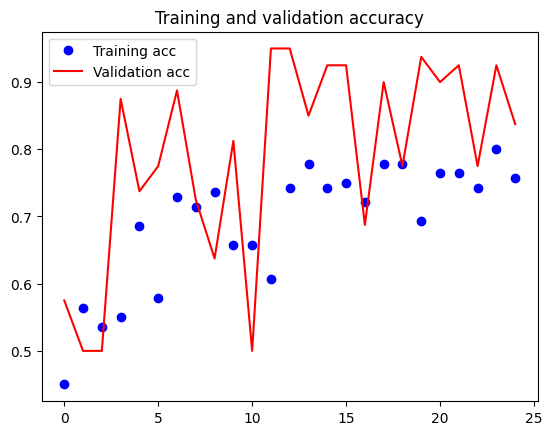

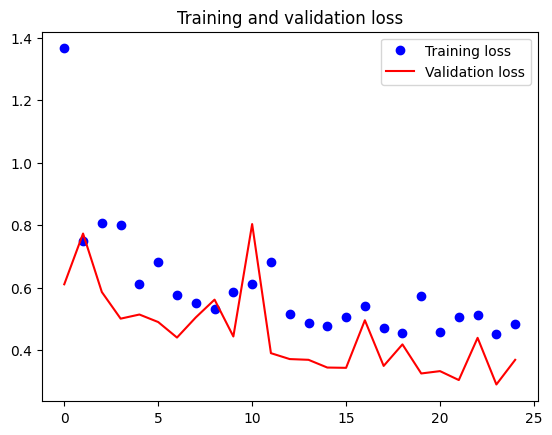

In [ ]:
import matplotlib.pyplot as plt

acc = vgg_base_fit_generator_do.history['acc']
val_acc = vgg_base_fit_generator_do.history['val_acc']
loss = vgg_base_fit_generator_do.history['loss']
val_loss = vgg_base_fit_generator_do.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
vgg_test_generator_do = vgg_test_datagen_do.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames_do = vgg_test_generator_do.filenames
nb_samples_do = len(filenames_do)

predict_do = vgg_transfer_base_model.predict_generator(vgg_test_generator_do,steps = nb_samples_do, verbose=2)

Found 24 images belonging to 2 classes.


<ipython-input-27-27498633ff42>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict_do = vgg_transfer_base_model.predict_generator(vgg_test_generator_do,steps = nb_samples_do, verbose=2)


24/24 - 16s - 16s/epoch - 654ms/step


Confusion matrix, without normalization
[[12  0]
 [ 5  7]]


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

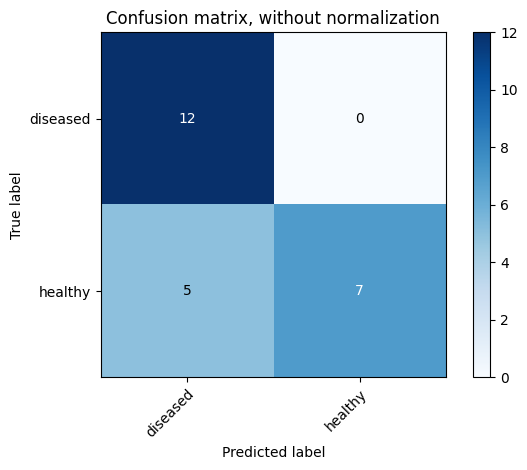

In [ ]:
do_y_true = vgg_test_generator_do.classes
do_y_pred = predict_do.argmax(axis=1)
plot_confusion_matrix(do_y_true, do_y_pred, classes=['diseased','healthy',],
                      title='Confusion matrix, without normalization')

In [ ]:
from keras.applications import ResNet50

resnet50_base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
base_x = resnet50_base_model.output
global_pooling_x = GlobalAveragePooling2D()(base_x)
#add dense layer
dense_layer = Dense(512, activation='relu')(global_pooling_x)
#add final output layer
base_prediction = Dense(2, activation = 'softmax')(dense_layer)

#create the whole network
resnet_transfer_model_1 = Model(resnet50_base_model.input, base_prediction)

resnet_transfer_model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

res_train_datagen = ImageDataGenerator(
        rotation_range=60,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

res_test_datagen = ImageDataGenerator(rescale=1./255)

res_train_generator = res_train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

res_validation_generator = res_test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames_res = res_train_generator.filenames
steps_train_res = len(train_filenames_res)/res_train_generator.batch_size

## set steps per epoch for validation
validation_filenames_res = res_validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/res_validation_generator.batch_size


print(len(validation_filenames_res), " ", steps_valid_res)

Found 140 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
140   14.0


In [ ]:
import keras.utils

res_train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
res_test_datagen = ImageDataGenerator(rescale=1./255)

## train generator
res_train_generator = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
res_validation_generator = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
resnet_transfer_model_1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_res = res_train_generator.filenames
steps_train_res = len(train_filenames_res)/res_train_generator.batch_size

## set steps per epoch for validation
validation_filenames_res = res_validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/res_validation_generator.batch_size


resnet_model_1_fit_generator = resnet_transfer_model_1.fit_generator(
        res_train_generator,
        steps_per_epoch=steps_train_res,
        epochs=30,
        validation_data=res_validation_generator,
        validation_steps=steps_valid_do,
        verbose=1)

Found 140 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-61-df262035b01e>:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_model_1_fit_generator = resnet_transfer_model_1.fit_generator(


Epoch 1/30
5/5 [==============================] - 77s 14s/step - loss: 2.1430e-04 - acc: 1.0000 - val_loss: 2.2816 - val_acc: 0.5000
Epoch 2/30
6/5 [================================] - ETA: -3s - loss: 2.2130e-05 - acc: 1.0000

KeyboardInterrupt: ignored

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')
])

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       46592     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                                 
                                                      

In [ ]:
history=model.fit(
    res_train_generator,
    epochs=25,
    validation_data=res_validation_generator,
    validation_steps=steps_valid_do,
        verbose=1
)

Epoch 1/50


InvalidArgumentError: ignored

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit_generator(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=25,
      validation_data=validation_batches,
      validation_steps=steps_valid)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-10-27e80d41d4de>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_generator1 = model.fit_generator(


Epoch 1/25
2/2 [==============================] - 147s 59s/step - loss: 23.0785 - acc: 0.5143 - val_loss: 0.7425 - val_acc: 0.5000
Epoch 2/25
2/2 [==============================] - 69s 30s/step - loss: 3.2355 - acc: 0.5571 - val_loss: 1.1569 - val_acc: 0.5000
Epoch 3/25
2/2 [==============================] - 70s 32s/step - loss: 1.8826 - acc: 0.5143 - val_loss: 3.1501 - val_acc: 0.5000
Epoch 4/25
2/2 [==============================] - 71s 31s/step - loss: 1.8724 - acc: 0.5429 - val_loss: 1.0584 - val_acc: 0.5125
Epoch 5/25
2/2 [==============================] - 70s 30s/step - loss: 1.1415 - acc: 0.6214 - val_loss: 0.4024 - val_acc: 0.8750
Epoch 6/25
2/2 [==============================] - 69s 29s/step - loss: 1.0486 - acc: 0.5857 - val_loss: 1.5047 - val_acc: 0.5000
Epoch 7/25
2/2 [==============================] - 71s 32s/step - loss: 0.7158 - acc: 0.7643 - val_loss: 0.3981 - val_acc: 0.7500
Epoch 8/25
2/2 [==============================] - 73s 34s/step - loss: 0.4133 - acc: 0.7714 - v

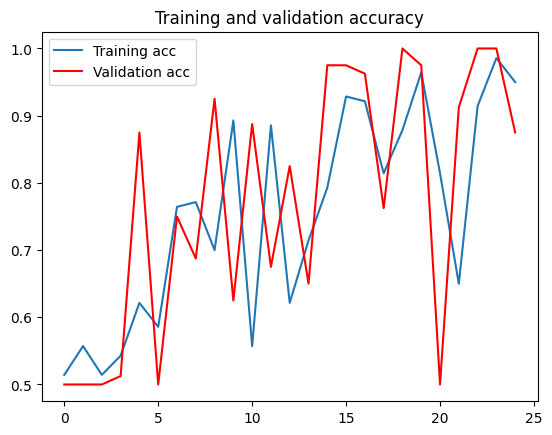

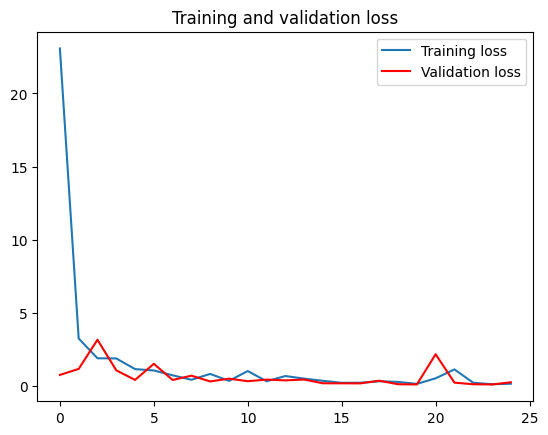

In [ ]:
import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 24 images belonging to 2 classes.


<ipython-input-12-9ce26b8cb32a>:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model_predict = model.predict_generator(model_test_generator,steps = nb_samples, verbose=2)


24/24 - 16s - 16s/epoch - 656ms/step
Confusion matrix, without normalization
[[ 6  6]
 [ 0 12]]
['diseased/0020_0031.JPG', 'diseased/0020_0032.JPG', 'diseased/0020_0033.JPG', 'diseased/0020_0034.JPG', 'diseased/0020_0035.JPG', 'diseased/0020_0036.JPG', 'diseased/0020_0037.JPG', 'diseased/0020_0038.JPG', 'diseased/0020_0039.JPG', 'diseased/0020_0040.JPG', 'diseased/0020_0041.JPG', 'diseased/0020_0042.JPG', 'healthy/0009_0031.JPG', 'healthy/0009_0032.JPG', 'healthy/0009_0033.JPG', 'healthy/0009_0034.JPG', 'healthy/0009_0035.JPG', 'healthy/0009_0036.JPG', 'healthy/0009_0037.JPG', 'healthy/0009_0038.JPG', 'healthy/0009_0039.JPG', 'healthy/0009_0040.JPG', 'healthy/0009_0041.JPG', 'healthy/0009_0042.JPG']


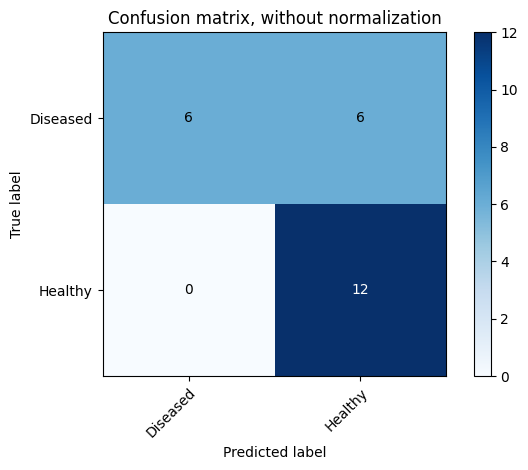

In [ ]:
model_test_datagen = ImageDataGenerator(rescale=1./255)

model_test_generator = model_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = model_test_generator.filenames
nb_samples = len(filenames)

model_predict = model.predict_generator(model_test_generator,steps = nb_samples, verbose=2)
y_true = model_test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Diseased','Healthy'],

                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_3 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 140 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-13-3ef064f0e499>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_generator_3 = model.fit_generator(


Epoch 1/20
2/2 [==============================] - 75s 32s/step - loss: 0.6812 - acc: 0.5929 - val_loss: 0.6394 - val_acc: 0.5000
Epoch 2/20
2/2 [==============================] - 70s 32s/step - loss: 0.6138 - acc: 0.5214 - val_loss: 0.6147 - val_acc: 0.6750
Epoch 3/20
2/2 [==============================] - 72s 32s/step - loss: 0.5296 - acc: 0.7786 - val_loss: 0.5695 - val_acc: 0.5125
Epoch 4/20
2/2 [==============================] - 74s 34s/step - loss: 0.6223 - acc: 0.5714 - val_loss: 0.4429 - val_acc: 0.9750
Epoch 5/20
2/2 [==============================] - 74s 33s/step - loss: 0.4444 - acc: 0.9214 - val_loss: 0.3922 - val_acc: 0.9750
Epoch 6/20
2/2 [==============================] - 74s 31s/step - loss: 0.4502 - acc: 0.8714 - val_loss: 0.4459 - val_acc: 0.6500
Epoch 7/20
2/2 [==============================] - 73s 30s/step - loss: 0.4015 - acc: 0.8357 - val_loss: 0.3791 - val_acc: 0.7750
Epoch 8/20
2/2 [==============================] - 71s 32s/step - loss: 0.3573 - acc: 0.9000 - val